In [1]:
import os
import sys
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, MultiHeadAttention
import yaml

# Set up paths
project_root = "/rsrch5/home/plm/yshokrollahi/vitamin-p/vitamin-p"
src_dir = os.path.join(project_root, 'src')
sys.path.insert(0, project_root)
sys.path.insert(0, src_dir)

# Import custom layers
from src.models.vit import PatchEmbedding, TransformerBlock

# Paths
config_path = os.path.join(project_root, "configs/training_config.yaml")

# Load configuration
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

# Update paths with project root
for key in ['model_checkpoint_path', 'final_model_path', 'encoder_model_path']:
    config[key] = os.path.join(project_root, config[key])

def load_latest_model(config):
    # Define custom objects
    custom_objects = {
        'PatchEmbedding': PatchEmbedding,
        'TransformerBlock': TransformerBlock,
        # Add any other custom objects your model might use
    }

    # First, try to load the final model
    if os.path.exists(config['final_model_path']):
        print(f"Loading final model from: {config['final_model_path']}")
        return tf.keras.models.load_model(config['final_model_path'], custom_objects=custom_objects, compile=False)
    
    # If final model doesn't exist, look for the latest checkpoint
    checkpoint_dir = os.path.dirname(config['model_checkpoint_path'])
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.h5')]
    if not checkpoints:
        raise FileNotFoundError(f"No model checkpoints found in {checkpoint_dir}")
    
    latest_checkpoint = max(checkpoints, key=lambda x: os.path.getctime(os.path.join(checkpoint_dir, x)))
    latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    
    print(f"Final model not found. Loading latest checkpoint from: {latest_checkpoint_path}")
    return tf.keras.models.load_model(latest_checkpoint_path, custom_objects=custom_objects, compile=False)

# Load the model
try:
    model = load_latest_model(config)
    print("Model loaded successfully!")
    model.summary()
except Exception as e:
    print(f"Error loading the model: {str(e)}")
    raise

2024-08-03 18:32:41.405018: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-03 18:32:41.434549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 18:32:41.434569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 18:32:41.435346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 18:32:41.440168: I tensorflow/core/platform/cpu_feature_guar

Loading final model from: /rsrch5/home/plm/yshokrollahi/vitamin-p/vitamin-p/models/saved_models/final_model.h5


2024-08-03 18:32:43.058578: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2348] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 9.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2024-08-03 18:32:43.060653: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2348] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 9.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2024-08-03 18:32:43.062556: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2348] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 9.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2024-08-03 18:32:43.063797: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2348] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 9.0. CUDA kernels will be jit-compiled from PTX, whi

Model loaded successfully!
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 256, 64)              735488    ['input_2[0][0]']             
                                                                                                  
 dense_17 (Dense)            (None, 256, 65536)           4259840   ['model[0][0]']               
                                                                                                  
 reshape_1 (Reshape)         (None, 256, 256, 256)        0         ['dense_17[0][0]']            
                                                                 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
from src.data.preprocessing import preprocess_pannuke_data
from src.models.vit import PatchEmbedding, TransformerBlock

# Set up paths
project_root = "/rsrch5/home/plm/yshokrollahi/vitamin-p/vitamin-p"
config_path = os.path.join(project_root, "configs/training_config.yaml")

# Load configuration
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

# Update paths with project root
for key in ['model_checkpoint_path', 'final_model_path', 'encoder_model_path']:
    config[key] = os.path.join(project_root, config[key])

def load_latest_model(config):
    custom_objects = {
        'PatchEmbedding': PatchEmbedding,
        'TransformerBlock': TransformerBlock,
    }
    if os.path.exists(config['final_model_path']):
        print(f"Loading final model from: {config['final_model_path']}")
        return tf.keras.models.load_model(config['final_model_path'], custom_objects=custom_objects, compile=False)
    
    checkpoint_dir = os.path.dirname(config['model_checkpoint_path'])
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.h5')]
    if not checkpoints:
        raise FileNotFoundError(f"No model checkpoints found in {checkpoint_dir}")
    
    latest_checkpoint = max(checkpoints, key=lambda x: os.path.getctime(os.path.join(checkpoint_dir, x)))
    latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    
    print(f"Final model not found. Loading latest checkpoint from: {latest_checkpoint_path}")
    return tf.keras.models.load_model(latest_checkpoint_path, custom_objects=custom_objects, compile=False)

# Load the model
model = load_latest_model(config)
print("Model loaded successfully!")

# Load and preprocess the data
data_dir = '/rsrch5/home/plm/yshokrollahi/vitamin-p/vitamin-p/data/raw/H&E'
fold = 1  # You can change this to 2 or 3 for different folds
batch_size = 32
_, _, test_dataset, unique_types, _ = preprocess_pannuke_data(data_dir, fold, batch_size)

def display_sample_with_prediction(model, dataset, num_samples=2):
    for images, labels in dataset.take(1):
        for i in range(min(num_samples, images.shape[0])):
            image = images[i].numpy()
            ground_truth = labels['np_branch'][i].numpy()[..., 0]
            
            # Make prediction
            prediction = model.predict(tf.expand_dims(image, axis=0))
            predicted_mask = prediction[0][..., 0]  # Assuming 'np_branch' is the first output
            
            # Display
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            
            axs[0].imshow(image)
            axs[0].set_title('Original Image')
            axs[0].axis('off')
            
            axs[1].imshow(ground_truth, cmap='gray', vmin=0, vmax=1)
            axs[1].set_title('Ground Truth Mask')
            axs[1].axis('off')
            
            axs[2].imshow(predicted_mask, cmap='gray', vmin=0, vmax=1)
            axs[2].set_title('Predicted Mask')
            axs[2].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"Ground Truth unique values: {np.unique(ground_truth)}")
            print(f"Prediction unique values: {np.unique(predicted_mask)}")
            print(f"Ground Truth min: {np.min(ground_truth)}, max: {np.max(ground_truth)}")
            print(f"Prediction min: {np.min(predicted_mask)}, max: {np.max(predicted_mask)}")
            print("=" * 50)

# Display samples with predictions
display_sample_with_prediction(model, test_dataset, num_samples=2)

Model loaded successfully!


2024-08-03 18:32:59.498007: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


1/1 [==============================] - 3s 3s/step
Prediction made successfully!


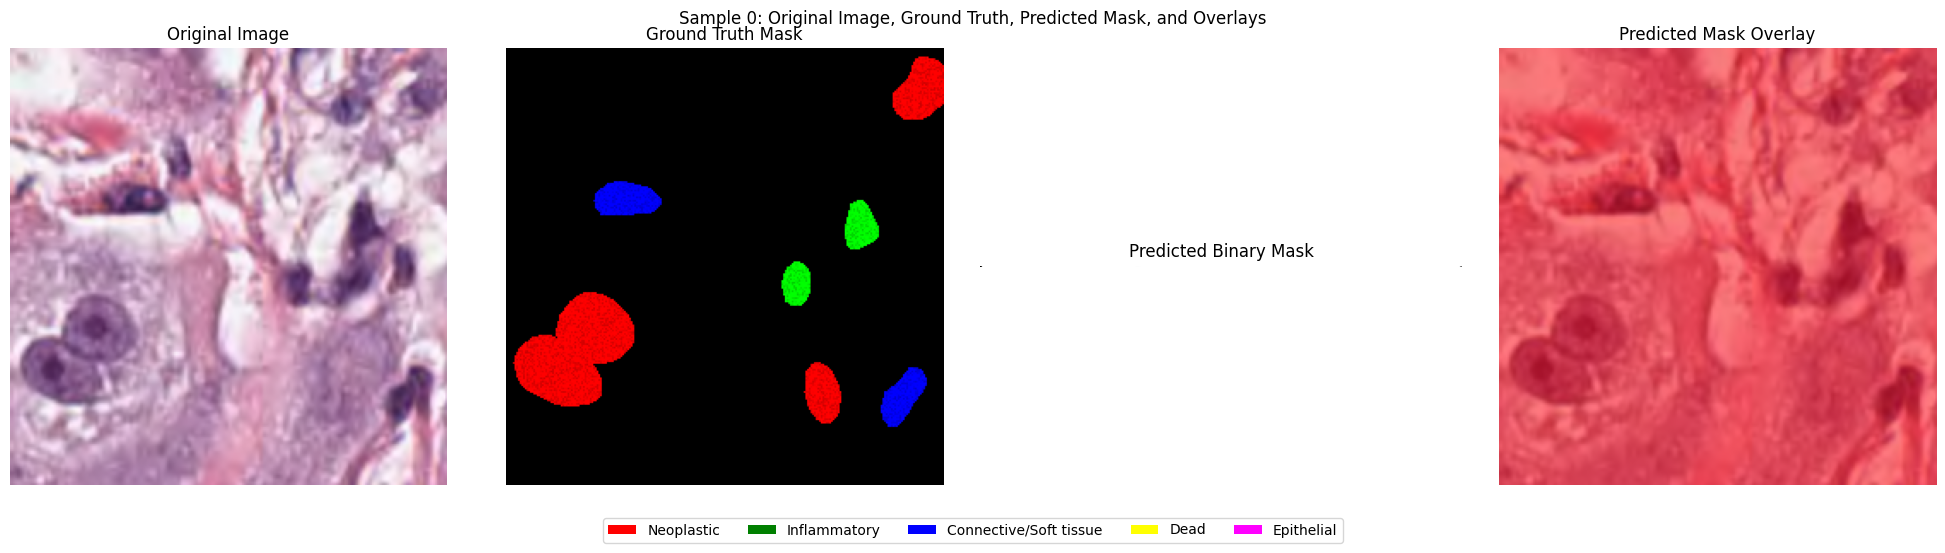

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import tensorflow as tf
import yaml

# Set up paths
project_root = "/rsrch5/home/plm/yshokrollahi/vitamin-p/vitamin-p"
src_dir = os.path.join(project_root, 'src')
sys.path.insert(0, project_root)
sys.path.insert(0, src_dir)

# Import custom layers
from src.models.vit import PatchEmbedding, TransformerBlock

# Visualization functions
def color_jitter(mask, color, jitter_range=0.2):
    jittered = np.random.uniform(1-jitter_range, 1+jitter_range, size=mask.shape[:2])
    return np.clip(mask[:,:,np.newaxis] * color * jittered[:,:,np.newaxis], 0, 1)

def create_colored_mask(mask):
    colors = [
        [1, 0, 0],    # Red (Neoplastic)
        [0, 1, 0],    # Green (Inflammatory)
        [0, 0, 1],    # Blue (Connective/Soft tissue)
        [1, 1, 0],    # Yellow (Dead)
        [1, 0, 1],    # Magenta (Epithelial)
    ]
    
    colored_mask = np.zeros((*mask.shape[:2], 3))
    for i in range(5):  # 5 cell classes
        cell_mask = mask[..., i] > 0
        labeled, num_features = ndimage.label(cell_mask)
        for j in range(1, num_features+1):
            cell = (labeled == j)
            colored_mask += color_jitter(cell, colors[i])
    
    # Set background to black
    background = mask[..., 5] > 0 if mask.shape[-1] > 5 else np.sum(mask, axis=-1) == 0
    colored_mask[background] = [0, 0, 0]
    
    # Normalize non-background areas
    non_background = ~background
    if np.any(non_background):
        colored_mask[non_background] /= np.max(colored_mask[non_background])
    
    return colored_mask

def overlay_mask_on_image(image, colored_mask, alpha=0.5):
    return image * (1 - alpha) + colored_mask * alpha

def visualize_single_sample(image, true_mask, pred_mask, sample_index):
    class_names = ['Neoplastic', 'Inflammatory', 'Connective/Soft tissue', 'Dead', 'Epithelial', 'Background']
    colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'black']

    # Normalize image if necessary
    if image.max() > 1:
        image = image / 255.0

    # Create colored masks
    colored_true_mask = create_colored_mask(true_mask)
    colored_pred_mask = np.zeros_like(colored_true_mask)
    colored_pred_mask[:,:,0] = pred_mask  # Assuming pred_mask is binary

    # Create overlays
    true_overlay = overlay_mask_on_image(image, colored_true_mask)
    pred_overlay = overlay_mask_on_image(image, colored_pred_mask)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Sample {sample_index}: Original Image, Ground Truth, Predicted Mask, and Overlays')

    # Original Image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Ground Truth Mask
    axes[1].imshow(colored_true_mask)
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Predicted Binary Mask
    axes[2].imshow(pred_mask, cmap='gray')
    axes[2].set_title('Predicted Binary Mask')
    axes[2].axis('off')

    # Overlay of Predicted Mask on Image
    axes[3].imshow(pred_overlay)
    axes[3].set_title('Predicted Mask Overlay')
    axes[3].axis('off')

    # Add legend for ground truth mask
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='none', label=name) 
                       for color, name in zip(colors[:-1], class_names[:-1])]  # Exclude background
    fig.legend(handles=legend_elements, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.1))

    plt.tight_layout()
    plt.show()

# Load configuration and model
config_path = os.path.join(project_root, "configs/training_config.yaml")
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

for key in ['model_checkpoint_path', 'final_model_path', 'encoder_model_path']:
    config[key] = os.path.join(project_root, config[key])

custom_objects = {
    'PatchEmbedding': PatchEmbedding,
    'TransformerBlock': TransformerBlock,
}

model = tf.keras.models.load_model(config['final_model_path'], custom_objects=custom_objects, compile=False)
print("Model loaded successfully!")

# Load sample data
image_file = os.path.join(project_root, "data/raw/H&E/Fold 1/images/fold1/images.npy")
mask_file = os.path.join(project_root, "data/raw/H&E/Fold 1/masks/fold1/masks.npy")

images = np.load(image_file, allow_pickle=True)
masks = np.load(mask_file, allow_pickle=True)

# Make a prediction for a single sample
sample_index = 0  # You can change this to visualize different samples
sample_image = images[sample_index]
sample_true_mask = masks[sample_index]

# Ensure the image has the correct shape for the model
if len(sample_image.shape) == 3:
    sample_image = np.expand_dims(sample_image, axis=0)
elif len(sample_image.shape) == 2:
    sample_image = np.expand_dims(np.expand_dims(sample_image, axis=0), axis=-1)

# Make prediction
try:
    sample_pred_mask = model.predict(sample_image)[0]  # Assuming the NP branch is the first output
    print("Prediction made successfully!")
except Exception as e:
    print(f"Error making prediction: {str(e)}")
    raise

# Ensure the predicted mask is 2D
if len(sample_pred_mask.shape) > 2:
    sample_pred_mask = sample_pred_mask[:,:,0]  # Take the first channel if it's multi-channel

# Visualize the single sample
visualize_single_sample(images[sample_index], sample_true_mask, sample_pred_mask, sample_index)

In [3]:
# Assuming you've already loaded the model and sample image as before

# Make prediction
sample_pred = model.predict(sample_image)

# Extract NP branch prediction (assuming it's the first output)
np_pred = sample_pred[0]

print("NP Branch Output Shape:", np_pred.shape)
print("NP Branch Output Min Value:", np_pred.min())
print("NP Branch Output Max Value:", np_pred.max())
print("NP Branch Output Mean Value:", np_pred.mean())

# Print histogram data
import numpy as np

hist, bin_edges = np.histogram(np_pred, bins=10)
print("\nHistogram of NP Branch Output:")
for i in range(len(hist)):
    print(f"Bin {i+1} ({bin_edges[i]:.4f} to {bin_edges[i+1]:.4f}): {hist[i]} values")

# Check if output is binary or continuous
is_binary = np.allclose(np_pred, np.round(np_pred))
print("\nIs the output binary?", is_binary)

# If not binary, suggest a threshold
if not is_binary:
    suggested_threshold = np.mean([np_pred.min(), np_pred.max()])
    print(f"Suggested threshold for binarization: {suggested_threshold:.4f}")

# Print a small sample of the output
print("\nSample of NP Branch Output (5x5 patch):")
print(np_pred[0, :5, :5, 0])  # Assuming the output is 4D: (batch, height, width, channels)

1/1 [==============================] - 0s 90ms/step
NP Branch Output Shape: (1, 256, 256, 1)
NP Branch Output Min Value: 0.99919194
NP Branch Output Max Value: 1.0
NP Branch Output Mean Value: 1.0

Histogram of NP Branch Output:
Bin 1 (0.9992 to 0.9993): 1 values
Bin 2 (0.9993 to 0.9994): 0 values
Bin 3 (0.9994 to 0.9994): 0 values
Bin 4 (0.9994 to 0.9995): 0 values
Bin 5 (0.9995 to 0.9996): 0 values
Bin 6 (0.9996 to 0.9997): 1 values
Bin 7 (0.9997 to 0.9998): 0 values
Bin 8 (0.9998 to 0.9998): 0 values
Bin 9 (0.9998 to 0.9999): 1 values
Bin 10 (0.9999 to 1.0000): 65533 values

Is the output binary? False
Suggested threshold for binarization: 0.9996

Sample of NP Branch Output (5x5 patch):
[[0.99990034 0.9999994  0.9999999  0.9999999  0.99999976]
 [0.99999976 1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]]


1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


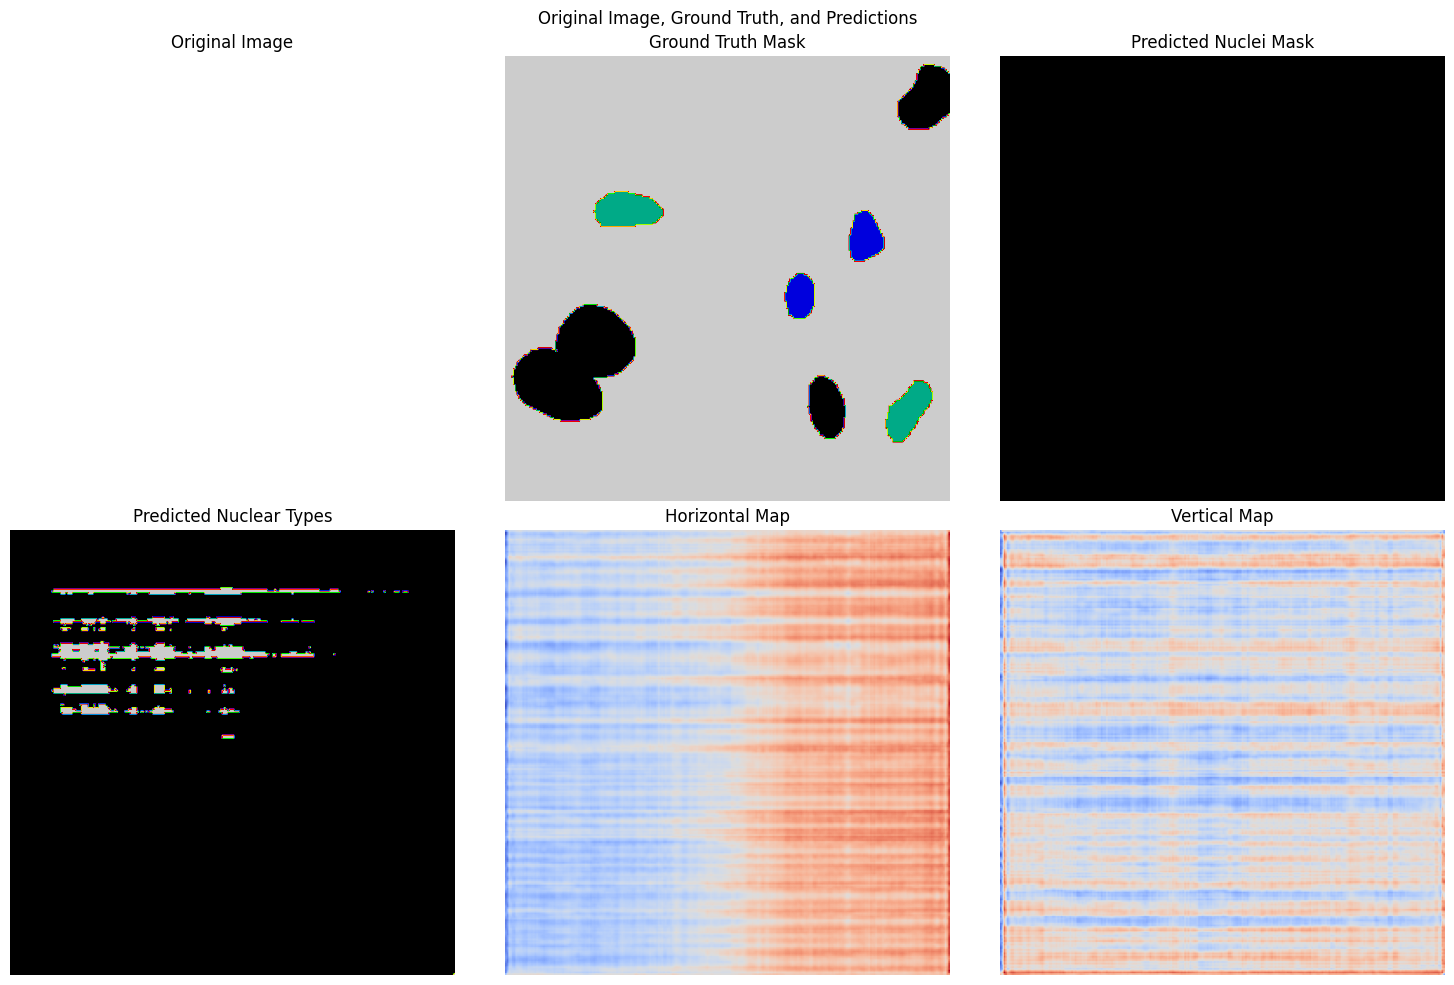

Nuclei Prediction - Accuracy: 1.0000, F1 Score: 1.0000


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Normalize input image
def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())

# 2. Update prediction function to use all branches
def predict_all_branches(model, image):
    normalized_image = normalize_image(image)
    predictions = model.predict(normalized_image)
    return {
        'np': predictions[0],  # Nuclei prediction
        'hv': predictions[1],  # Horizontal and vertical maps
        'nt': predictions[2],  # Nuclear type prediction
        'tc': predictions[3]   # Tissue type classification
    }

# 3. Post-process predictions
def post_process_predictions(predictions):
    np_mask = (predictions['np'] > 0.5).astype(np.uint8)
    nt_mask = np.argmax(predictions['nt'], axis=-1)
    return np_mask, nt_mask

# 4. Updated visualization function
def visualize_predictions(image, true_mask, predictions):
    np_mask, nt_mask = post_process_predictions(predictions)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Original Image, Ground Truth, and Predictions')
    
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(np.argmax(true_mask, axis=-1), cmap='nipy_spectral')
    axes[0, 1].set_title('Ground Truth Mask')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(np_mask[0, ..., 0], cmap='gray')
    axes[0, 2].set_title('Predicted Nuclei Mask')
    axes[0, 2].axis('off')
    
    axes[1, 0].imshow(nt_mask[0], cmap='nipy_spectral')
    axes[1, 0].set_title('Predicted Nuclear Types')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(predictions['hv'][0, ..., 0], cmap='coolwarm')
    axes[1, 1].set_title('Horizontal Map')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(predictions['hv'][0, ..., 1], cmap='coolwarm')
    axes[1, 2].set_title('Vertical Map')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# 5. Main execution
sample_index = 0
sample_image = images[sample_index:sample_index+1]  # Keep batch dimension
sample_true_mask = masks[sample_index]

predictions = predict_all_branches(model, sample_image)
visualize_predictions(images[sample_index], sample_true_mask, predictions)

# 6. Print model performance metrics (optional)
from sklearn.metrics import accuracy_score, f1_score

np_true = (np.sum(sample_true_mask, axis=-1) > 0).astype(np.uint8)
np_pred = (predictions['np'][0, ..., 0] > 0.5).astype(np.uint8)

accuracy = accuracy_score(np_true.flatten(), np_pred.flatten())
f1 = f1_score(np_true.flatten(), np_pred.flatten(), average='weighted')

print(f"Nuclei Prediction - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")